# Ground-roll attenuation model with attention

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sh

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V, B, L, I
from seismicpro.batchflow.models.tf.layers import conv_block

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import UnetAtt, attention_loss, FieldMetrics

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


Index dataset

In [2]:
# path_raw = '/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
# path_lift = '/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,1657,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,1655,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,1658,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,1654,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 10 field records for model training:

In [3]:
tindex = TraceIndex(index.create_subset(index.indices[:19]))
# tindex = tindex.filter('offset', lambda x: x < 3000)
train_set = SeismicDataset(tindex)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model config and loss function:

In [4]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

    'loss': (attention_loss, {'alpha': 0.05, 'beta': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.001}),
    'common/data_format': 'channels_last',
    'body': {'main': {
                    'encoder/num_stages': 5,
                    'encoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128, 256], kernel_size=7, activation=tf.nn.elu),
                    'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),

                    'decoder/num_stages': 5,
                    'decoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128, 256][::-1], kernel_size=7, activation=tf.nn.elu),
                    'decoder/upsample': dict(layout='tad', kernel_size=7, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),
                    },
             'attn': {
                    'encoder/num_stages': 4,
                    'encoder/blocks': dict(layout='caca', filters=[8, 16, 32, 64], kernel_size=3, activation=tf.nn.elu),
                    'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),

                    'decoder/num_stages': 4,
                    'decoder/blocks': dict(layout='caca', filters=[8, 16, 32, 64][::-1], kernel_size=3, activation=tf.nn.elu),
                    'decoder/upsample': dict(layout='tad', kernel_size=3, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),
                    },
                   },
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.0001

Loss balance: 0.05

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 2.

Define a train pipeline:

In [6]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw),
            'lift': exp_stack(batch.lift)}

train_pipeline = (Pipeline()
                  .init_model('static', UnetAtt, name='unet', config=model_config)
                  .init_variable('train_loss', default=list())
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches=['loss', 'cone_loss', 'sigm_loss'],
                               save_to=V('train_loss', 'a'))
                 )

Specify a dataset for model training:

In [7]:
train_pipeline = train_pipeline << train_set

Run model training for 3 epochs with batch size of 64:

In [8]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=5, drop_last=True,
                                    shuffle=True, bar=True)

  0%|          | 0/5130 [00:00<?, ?it/s]../../../seismicpro/batchflow/batchflow/batch.py:297: UserWarning: All batch data is erased
  warnings.warn("All batch data is erased")
100%|██████████| 5130/5130 [26:16<00:00,  3.14it/s]


Plot of loss terms decay:

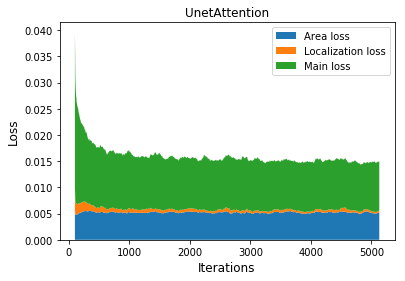

In [224]:
loss = np.array(train_pipeline.get_variable('train_loss'))

df = pd.DataFrame(loss[:, [1, 2, 0]])
df[[0, 1]] = df[[0, 1]] * 0.05
df[2] -= df[0] + df[1]

avl = df.rolling(100).mean().values
plt.stackplot(np.arange(len(avl)), avl.T,
              labels=['Area loss','Localization loss','Main loss'])
plt.legend(fontsize=10)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('UnetAttention')
plt.savefig('att_loss.eps')
plt.show()

In [237]:
!mkdir /data/NA/tmp2

In [41]:
model_path = './unet_att_model'
train_pipeline.save_model_now('unet', model_path)

In [45]:
np.savez('att_loss', loss)

## Inference

For inference we need a ```TraceIndex```, we also keep all SEGY headers from original traces:

In [129]:
inference_index = TraceIndex(name='raw', extra_headers='all', path=path_raw)

Inference pipeline. Note that one should specify temporary folder where processed batches will be stored before final merge.

In [130]:
tmp_dump_path = '/data/NA/tmp'

def make_data_inference(batch, **kwagrs):
    return {"feed_dict": {'trace_raw': exp_stack(batch.raw)}}

inference_ppl = (Pipeline()
                 .import_model('unet', train_pipeline)
#                  .load_model("static", UnetAtt, 'unet', path=model_path)    # Use this action instead of `import_model` if you didn't run training
                 .init_variable('res')
                 .load(components='raw', fmt='segy', tslice=np.arange(3000))
                 .predict_model('unet', make_data=make_data_inference,
                                fetches=['out_lift'], save_to=B('raw'))
                 .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()),
                       src='raw', fmt='segy', split=False)
                 )

Specify a dataset for inference pipeline:

In [131]:
inference_set = SeismicDataset(inference_index)

inference_ppl = inference_ppl << inference_set

Run inference pipeline with appropriate ```batch_size```:

In [132]:
batch_size = 2000
inference_ppl.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

  0%|          | 0/88 [00:00<?, ?it/s]../../../seismicpro/batchflow/batchflow/batch.py:297: UserWarning: All batch data is erased
  warnings.warn("All batch data is erased")
100%|██████████| 88/88 [04:31<00:00,  4.28s/it]


Final and rather optional step is to merge dumped files into a single file:

In [133]:
output_path = '/data/NA/processed/merged.sgy'
merge_segy_files(output_path=output_path, extra_headers='all',
                 path=os.path.join(tmp_dump_path, '*.sgy'))
sh.rm(sh.glob(os.path.join(tmp_dump_path, '*')))

100%|██████████| 88/88 [00:40<00:00,  2.23it/s]


For a quick estimation let's look at the first field record from the final file:

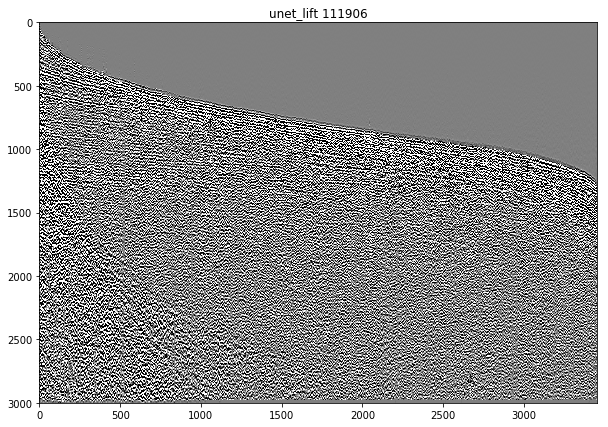

In [134]:
output_index = FieldIndex(name='unet_lift', extra_headers=['offset'], path=output_path)

(SeismicDataset(output_index).next_batch(1)
 .load(components='unet_lift', fmt='segy', tslice=np.arange(3000))
 .sort_traces(src='unet_lift', dst='unet_lift', sort_by='offset')
 .seismic_plot('unet_lift', index.indices[0], figsize=(10, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Running time

For GTX 1080 we obtain:
* training time per one batch of size 64 traces is 0.3 sec
* full model training time with batch size 64 is 8:50 min
* inference time per one batch of size 2500 traces is 3.78 sec

## Model evaluation

For model evaluation we 1) consider attention mask produced by model and compare it with thresholded absolute difference of target and input traces; 2) inspect attention mask parameters (sigmoid center and smoothness); 3) compare signal power spectrum in ground-roll area between target seismogram and model output.

Test pipeline:

In [10]:
model_path = './unet_att_model'
fetches=['out_lift', 'attention_sigmoid', 'att_sum']

def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data_test(batch, **kwagrs):
    return {"feed_dict": {'trace_raw': exp_stack(batch.raw)}}

test_pipeline = (Pipeline()
                 .import_model('unet', train_pipeline)
#                  .load_model("static", UnetAtt, 'unet', path=model_path)    # Use this action instead of `import_model` if you didn't run training
                 .init_variable('res', [])
                 .init_variable('raw', [])
                 .init_variable('lift', [])
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data_test, fetches=fetches, save_to=V('res', 'a')))

Select a sample seismogram for testing:

In [29]:
i = 29
test_set = SeismicDataset(TraceIndex(index.create_subset(index.indices[i: i+1])))

Run test pipeline:

In [30]:
test_pipeline = test_pipeline << test_set
test_pipeline = test_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Arrange results:

In [31]:
raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
att_sum = np.squeeze(np.vstack([x[2] for x in test_pipeline.get_variable('res')]))

### Visual estimation

Show raw seismogram, model attention mask, model output and difference between model output and raw input:

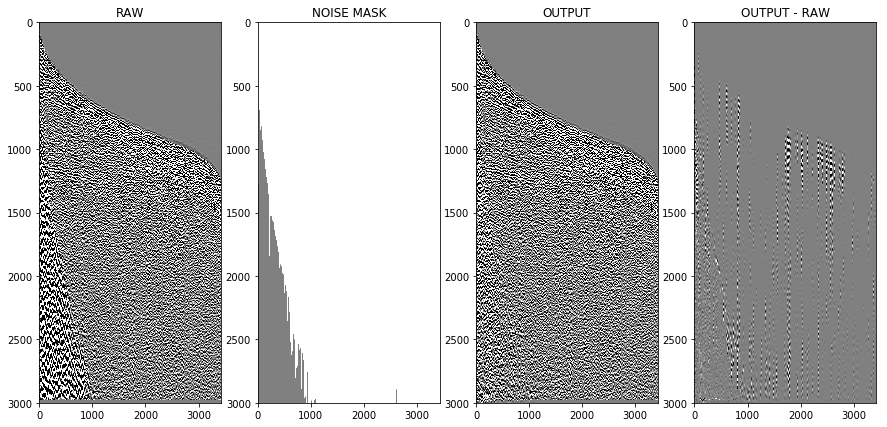

In [235]:
cv = 0.1
seismic_plot([raw, att, out, out - lift],
             figsize=(15, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW'],
             cmap='gray', vmin=-cv, vmax=cv)

Show model output, traget seismogram difference between them:

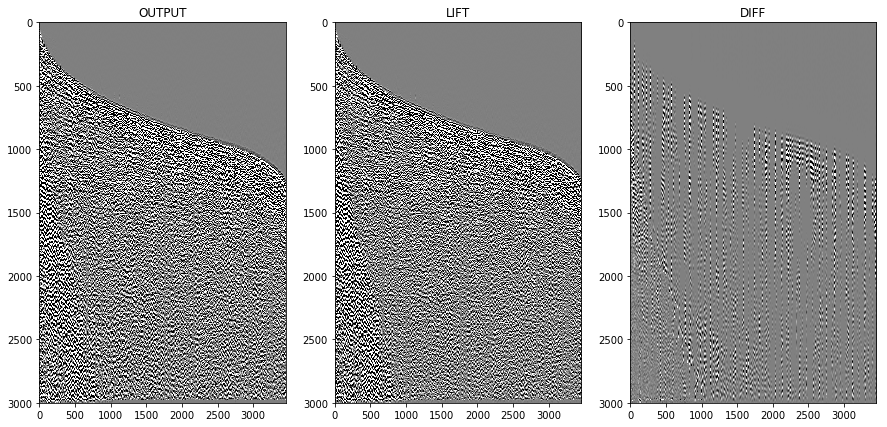

In [22]:
seismic_plot([out, lift, out - lift],
             figsize=(15, 7), names=['OUTPUT', 'LIFT', 'DIFF'],
             cmap='gray', vmin=-cv, vmax=cv)

Note a difference outside the ground-roll area.

### MAE metrics

Estimate MAE between model output and target seismogram:

In [33]:
mtr = FieldMetrics(lift, out)
print('MAE:', mtr.mae())

MAE: 0.005690455


MAE within predicted ground-roll cone:

In [34]:
mtr = FieldMetrics(lift[att < 0.5], out[att < 0.5])
print('MAE:', mtr.mae())
mtr = FieldMetrics(lift[att > 0.5], out[att > 0.5])
print('MAE:', mtr.mae())

MAE: 0.013168786
MAE: 0.0049307426


In [36]:
mtr = FieldMetrics(lift, out)
print('MSE:', mtr.mse())

MSE: 0.0017089784


In [66]:
mtr = FieldMetrics(lift[att < 0.5], out[att < 0.5])
print('MAE:', mtr.mse())

MAE: 0.0025473689


### Trace correlations

Get correlation coeffitiens between target traces and model output:

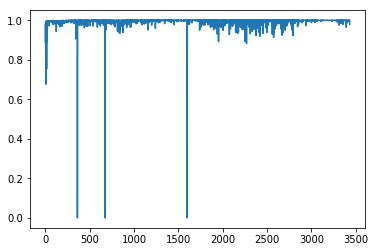

In [37]:
corr = mtr.corr_coef(reduce=None)
plt.plot(corr)
plt.show()

Note that zero correlation occurs due to zero traces in the dataset.

Average correlation is:

In [22]:
print('Averaged correlation:', mtr.corr_coef())

Averaged correlation: 0.9915477


### IOU for attention mask

Plot sigmoid center locations. We observe a non-trivial dependence of sigmoid parameters on traces and offsets: 

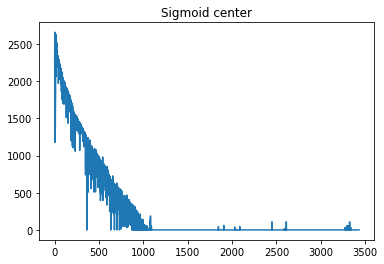

In [38]:
plt.plot((1 - att).sum(axis=1))
plt.title('Sigmoid center')
plt.show()

Comparison of attention mask and thresholded absolute difference between raw inputs and target traces:

In [210]:
0.06 / np.max(abs(lift - raw))
# np.max(abs(lift - raw)) / 100

0.005817725048775745

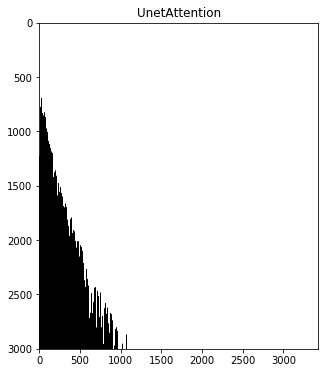

In [229]:
seismic_plot([att],
             names=['UnetAttention'],
             figsize=(5, 6), vmin=0, vmax=1, cmap='gray',
            save_to='noise_att.eps')

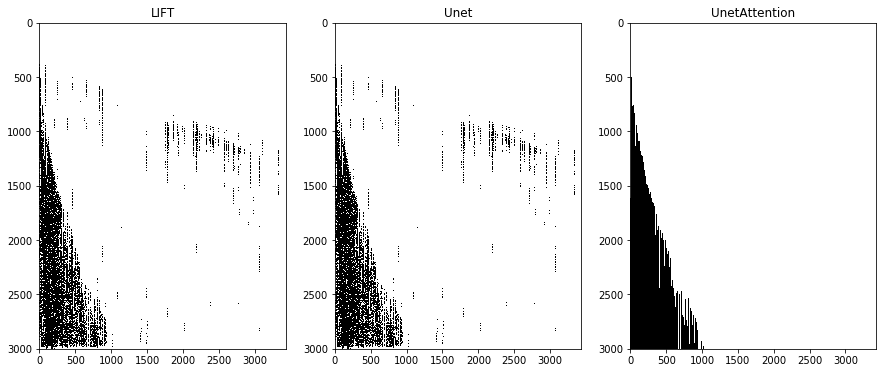

In [212]:
seismic_plot([abs(lift - raw) < .07, abs(lift - raw) < .07, att > 0.5],
             names=['LIFT', 'Unet', 'UnetAttention'],
             figsize=(15, 6), vmin=0, vmax=1, cmap='gray',
            save_to='masks.eps')

Compute IOU for various threshold values:

In [208]:
thrs = np.arange(0, .5, 0.01)
vals = np.array([FieldMetrics(abs(lift - raw) > p, att < 0.5).iou() for p in thrs])

Plot of IOU metrics aganist various threshold values. We find that threshold at 0.05 gives maximum of IOU:

Best threshold is 0.06 with IOU =  0.8100038897798858


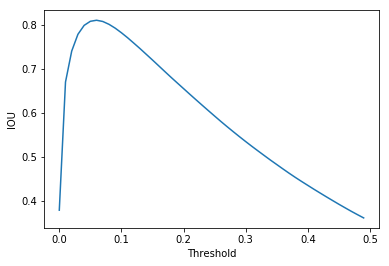

In [209]:
plt.plot(thrs, vals)
plt.xlabel('Threshold'), plt.ylabel('IOU')
print('Best threshold is', thrs[np.argmax(vals)], 'with IOU = ', vals.max())
plt.show()

### Power spectrum comparison

Power spectrum comparison in the gourd roll area:

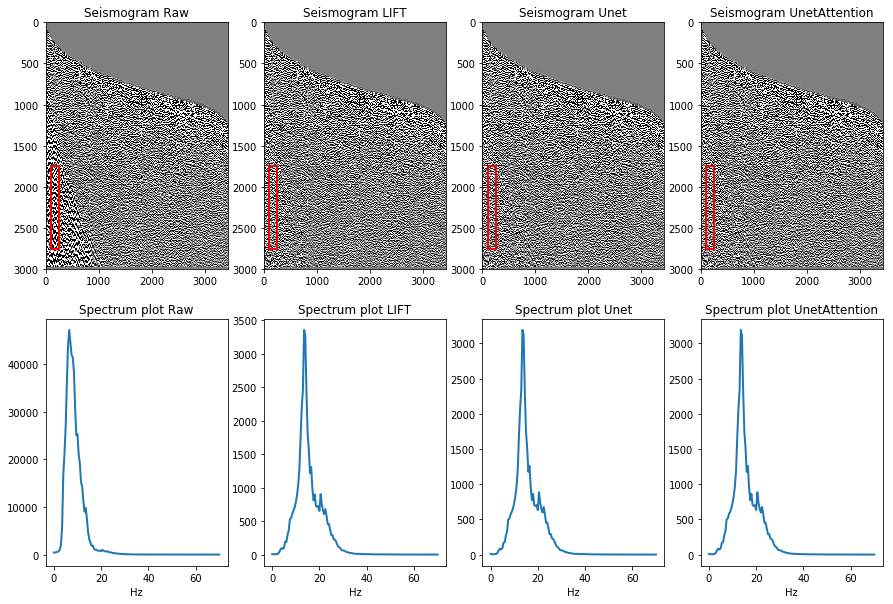

In [198]:
spectrum_plot([raw, lift, out, out],
              frame=(slice(100, 250), slice(1750, 2750)), rate=0.002, max_freq=70,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray',
              names=['Raw', 'LIFT', 'Unet', 'UnetAttention'],
             save_to='outputs.eps')

We observe a very similar distribution of power spectrum in the gound-roll area. We do not show plots outside the gound-roll area since the signal is unchanged there due to attention mask.

### Trace statistics comparison

Comparison of rms amplitudes:

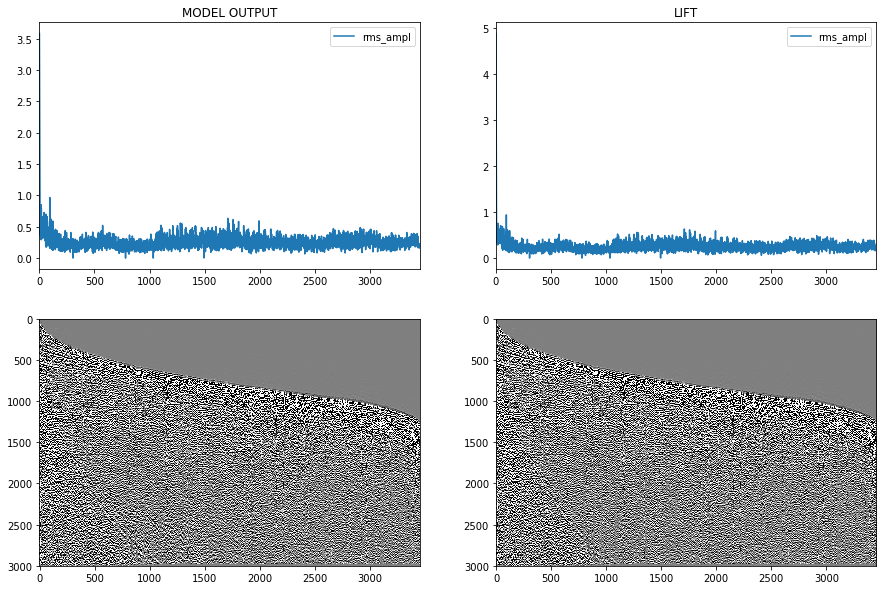

In [53]:
statistics_plot((out, lift), stats='rms_ampl', names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

Comparison of rms frequencies:

../../../seismicpro/src/plot_utils.py:318: RuntimeWarning: invalid value encountered in true_divide
  spec = spec / spec.sum(axis=1).reshape((-1, 1))


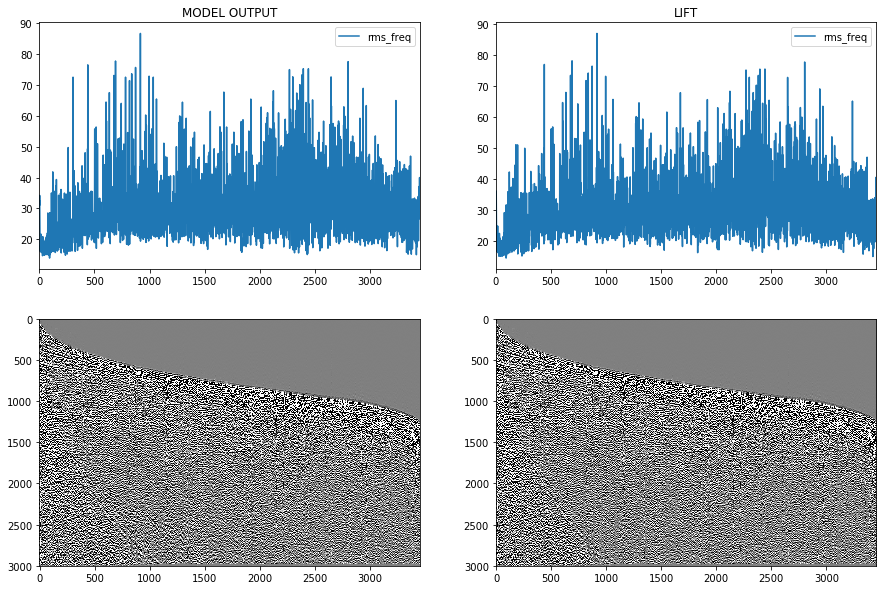

In [54]:
statistics_plot((out, lift), stats='rms_freq', rate=0.002,
                names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

We obsereve that while rms amplitudes are pretty the same, rms frequencies are somewhat differ for small offsets.

### Metrics evaluation on the whole dataset

We will evaluate MAE and averaged trace correlation for each seismogram. The result will be plotted in a scatter plot, where color indicates metrics value and point coordinates correspond to source coordinates.

Index traget and predicted seismograms:

In [135]:
path_raw = '/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_ml = '/data/NA/processed/merged.sgy'
path_lift = '/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

m_index = (FieldIndex(name='ml', extra_headers=['SourceX', 'SourceY'], path=path_ml)
           .merge(FieldIndex(name='lift', path=path_lift))
           .merge(FieldIndex(name='raw', path=path_raw)))

Define a dataset:

In [136]:
dset = SeismicDataset(m_index)

Define functions that extract source position and evaluate metrics and a pipeline that we will run on each seismogram:

In [230]:
def get_pos(batch, *args):
    sx = batch.trace_headers('SourceX', flatten=True)[0]
    sy = batch.trace_headers('SourceY', flatten=True)[0]
    ffid = batch.trace_headers('FieldRecord', flatten=True)[0]
    return sx, sy, ffid

def eval_mt(batch, *args):
#     mt = FieldMetrics(batch.lift[0], batch.ml[0], batch.raw[0])
    sl = (slice(100, 250), slice(1750, 2750))
    mt = FieldMetrics(batch.lift[0][sl], batch.ml[0][sl], batch.raw[0][sl])
    snr_1 = mt.signaltonoise(src='targets',
                              signal_frame=(slice(1000, 2000), slice(1500, 1650)),
                              noise_frame=(slice(50, 200), slice(1500, 2500)))
    snr_2 = mt.signaltonoise(src='predictions',
                              signal_frame=(slice(1000, 2000), slice(1500, 1650)),
                              noise_frame=(slice(50, 200), slice(1500, 2500)))
    snr = mt.signaltonoise2(src_clean='targets', src_noised='raw',
                           frame=(slice(50, 200), slice(1500, 2500)))
    snr2 = mt.signaltonoise2(src_clean='predictions', src_noised='raw',
                            frame=(slice(50, 200), slice(1500, 2500)))
    fsnr = mt.signaltonoise2(src_clean='targets', src_noised='raw')
    fsnr2 = mt.signaltonoise2(src_clean='predictions', src_noised='raw')
    return mt.mae(), mt.mse(), mt.corr_coef(), snr_1, snr_2, snr, snr2, fsnr, fsnr2
    

metr_pipeline = (Pipeline()
                 .init_variable('mt', [])
                 .init_variable('pos', [])
                 .load(components=('ml', 'lift', 'raw'), fmt='segy', tslice=np.arange(3000))
                 .call(get_pos, save_to=V('pos', mode='a'))
                 .call(eval_mt, save_to=V('mt', mode='a')))

Run the pipeline:

In [231]:
metr_pipeline = metr_pipeline << dset
metr_pipeline = metr_pipeline.run(batch_size=1, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

  0%|          | 0/51 [00:00<?, ?it/s]../../../seismicpro/batchflow/batchflow/batch.py:297: UserWarning: All batch data is erased
  warnings.warn("All batch data is erased")
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 51/51 [00:53<00:00,  1.02s/it]


Arrange results:

In [233]:
pos = np.vstack(metr_pipeline.get_variable('pos'))
mt = np.vstack(metr_pipeline.get_variable('mt'))

Plot MAE distribution over seismorams:

0.008


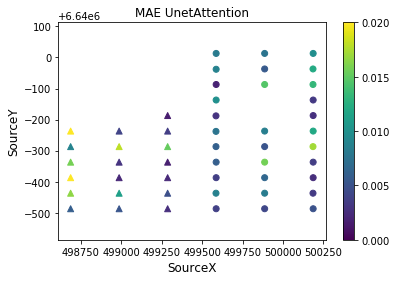

In [238]:
i = 0
vmin = 0
vmax = 0.02
plt.scatter(*pos[:19, :2].T, c=np.clip(mt[:19, i], 0, 500), marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=np.clip(mt[19:, i], 0, 500), vmin=vmin, vmax=vmax)
print('{:.3f}'.format(np.mean(mt[:, i])))
# for i in range(len(pos)):
#     plt.annotate(pos[i, 2].astype(str), pos[i, :2].T)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('MAE UnetAttention')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.ylim([6639413, 6640113])
# plt.savefig('snr_lift.eps')
plt.show()

174.012


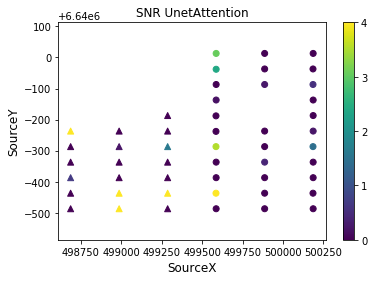

In [244]:
i = 8
vmin = 0
vmax = 4
plt.scatter(*pos[:19, :2].T, c=np.clip(mt[:19, i], 0, 500), marker="^", vmin=vmin, vmax=vmax)
plt.scatter(*pos[19:, :2].T, c=np.clip(mt[19:, i], 0, 500), vmin=vmin, vmax=vmax)
print('{:.3f}'.format(np.mean(mt[:, i])))
# for i in range(len(pos)):
#     plt.annotate(pos[i, 2].astype(str), pos[i, :2].T)
plt.colorbar(ticks=np.linspace(0, vmax, 5))
plt.title('SNR UnetAttention')
plt.xlabel('SourceX', fontsize=12)
plt.ylabel('SourceY', fontsize=12)
plt.ylim([6639413, 6640113])
# plt.savefig('snr_lift.eps')
plt.show()

Plot distribution of the averaged trace correlation over seismorams:

We observe that both metrics are distributed smoothly over seismorgams except for a single oulier (top-left point).

## Criticism

The model is not stable to intializations. Alternative initializations may produce sigmoid parameters depending on trace offset only or zero-constant values. However, it is more or less stable that 1 of 5 initializations results in reasonable sigmoid parameters.

## Conclusion

The Unet Attention model is possible tp provide reasonable noise attentiation in the ground-roll area and leaves signal untouched outside the ground-roll area due to in-situ estimated attention mask. However, traning of the model is sensitive to model initializations and requires accurate balansing of the loss terms. 

## Suggestions for improvements

Adding more constraints on sigmoid parameters to the loss function or clipping values inside the model should help to overcome the model instability. 